# Analysis and Machine Learning for Understanding The Impact of Geographical and Socioeconomic Factors on U.S. Home Prices
Authors: Grayson Gunderson and Victor Cairo

In [1]:
import os
from scipy.stats import shapiro
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
current_path = os.getcwd()
print(current_path)
from sklearn.preprocessing import MinMaxScaler
from read_data.read_listings_tracts_census import read_listings_tracts_census
from read_data.listings_and_tracts import merge_listings_and_tracts

/Users/vmcairos/Documents/github_personal/du/Final-Project-4447


ModuleNotFoundError: No module named 'listings_and_tracts'

The code block below leverages the imported function read_listings_tracts_census() from 'read_listings_tracts_census.py'. This function merges the three dataframes that were created in seperate python scripts into a single dataframe.

In [2]:
# import merged_df and read_listings_tracts_census() function
path_to_census = 'Census_Data'
path_to_listings = 'housing_api/listings'
path_to_tracts = 'shapefile_data'
merged_df = read_listings_tracts_census(
    path_to_census=path_to_census,
    path_to_listings=path_to_listings,
    path_to_tracts=path_to_tracts,
)

listings_tracts_df = merge_listings_and_tracts(
    path_to_listings=path_to_listings,
    path_to_tracts=path_to_tracts)

census_df = pd.read_parquet('Census_Data/df_census.parquet')

NameError: name 'read_listings_tracts_census' is not defined

In [3]:
merged_df

NameError: name 'merged_df' is not defined

## Descriptive Statistics
Many of the features in our data are on different scales. For example, the area features has a maximum value of 9.0, while median_house_hold income has a maximum value of 237,188.0. These differences in scale can lead to ML models overstating the importance of variables on a smaller scale, and understating the importance of of variables on a larger scale. 

In [4]:
merged_df.describe().T.round(1)

NameError: name 'merged_df' is not defined

## Missing Values Analysis

In [5]:
# Check for missing values in each column
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0].sort_values(ascending=False))

NameError: name 'merged_df' is not defined

In [6]:
# check which df NA values in merged_df are originating
listings_tracts_df.isna().sum()

NameError: name 'listings_tracts_df' is not defined

In [7]:
# check which df NA values in merged_df are originating
census_df.isna().sum()

NameError: name 'census_df' is not defined

# Distribution of Target-Variable

In [8]:
# plot distribution of 'price'
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['price'], kde=True)
plt.title('Distribution of Housing Price (Target-Variable)', fontweight='bold')
plt.tight_layout()
plt.show()

NameError: name 'merged_df' is not defined

<Figure size 1000x600 with 0 Axes>

The distribution of the target variable is right-skewed. There are a higher concentration of data points on the left. There are far more houses in the price-range 0 to 5 Million then there are in the price range of 5 Million to 10 Million. However there are houses that are priced far outside the typical range, the maximum of which is priced at 40 Million. This distribution implies that the mean housing price will be larger than the median housing price. 

In [9]:
median_price = np.median(merged_df['price'])
mean_price = np.mean(merged_df['price'])

print(f'Mean housing price: {mean_price}\nMedian housing price: {median_price}\n')
print('A Median less than the Mean is consistent with a right-skewed distribution which contain certain high-value observations that greatly influence the average value of all obervations.')

NameError: name 'merged_df' is not defined

The Mean value of housing price is 2x the Median value in our data set.

# Distribution of Key Numerical Features

NameError: name 'merged_df' is not defined

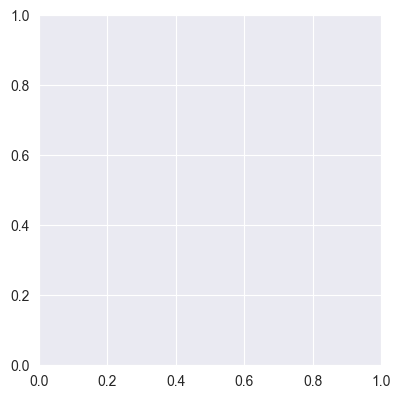

In [10]:
# columns to examine
columns_to_plot = ['bedrooms', 'bathrooms', 'squareFootage', 'median_monthly_housing_cost', 'median_household_income',
                   'area']

# Plot distributions
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(merged_df[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}', fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation Matrix of Key Numerical Features

In [11]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(merged_df[columns_to_plot].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features', fontweight='bold')
plt.show()


NameError: name 'merged_df' is not defined

<Figure size 1200x1000 with 0 Axes>

High Correlation may indicate multicollinearity between features. This could impact model efficacy if not handled properly. 

Features with high Correlation Values:
- bathrooms, bedrooms
- squareFootage, bathrooms
- squareFootage, bedrooms
- median_monthly_housing_cost, median_household_income

# Census Demographic Data vs. Property Features

NameError: name 'merged_df' is not defined

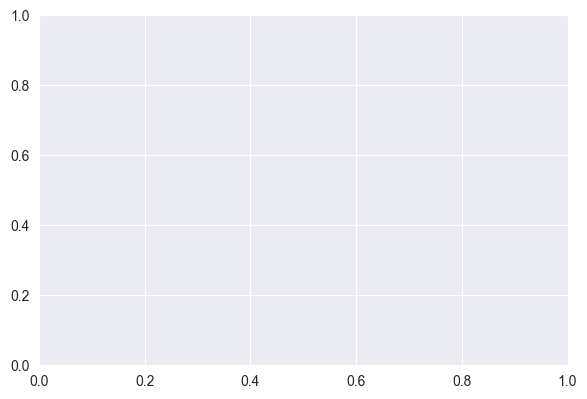

In [12]:
census_cols = ['total_pop', 'occupied_housing_units', 'median_monthly_housing_cost', 'median_household_income']

plt.figure(figsize=(15,10))
# Loop through each column in census_cols
for i, col in enumerate(census_cols, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    plt.scatter(merged_df[col], merged_df['price'], s=25, alpha=0.35)
    plt.title(f'{col} vs Price', fontweight='bold')
    plt.xlabel(col, fontweight='bold')
    plt.ylabel('Price', fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'merged_df' is not defined

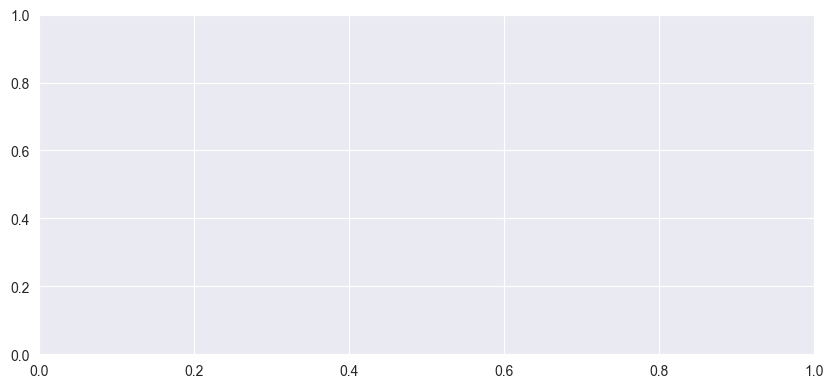

In [13]:
# percent occupied housing units across median household income brackets
census_cols = ['median_housing_income_below_100k', 'median_housing_income_100k_149k', 'median_housing_income_150k_above']

plt.figure(figsize=(10,15))
# Loop through each column in census_cols
for i, col in enumerate(census_cols, 1):
    plt.subplot(3, 1, i)  # create a 3x1 grid of subplots
    plt.scatter(merged_df[col], merged_df['price'], s=25, alpha=0.35)
    plt.title(f'{col} vs Price', fontweight='bold')
    plt.xlabel(col, fontweight='bold')
    plt.ylabel('Price', fontweight='bold')

plt.tight_layout()
plt.show()

### Correlation Between Income Features and Price

In [ ]:
# create function to plot the correlation matrix of all remaining features
def plot_corr(data: pd.DataFrame, title: str | None = None, columns_to_plot: list | None = None, annot: bool = False):
    """
    This function creates and displays a heatmap to visualize the correlations between selected features in a DataFrame.
    Params:
        data: pandas dataframe
        columns_to_plot: list. list of columns to plut
        annot: bool: if True, include the correlation percentage inside the cells.

    Returns:
    - Pandas Dataframe containing correlation coefficients of selected features
    """
    plt.figure(figsize=(12, 10))
    if columns_to_plot is None:
        columns_to_plot = data.columns.tolist()
    corr_df = data[columns_to_plot].corr()
    sns.heatmap(corr_df, annot=annot, cmap='RdBu', vmin=-1, vmax=1)
    if title is None:
        title = 'Correlation Matrix of Selected Features'
    plt.title(title, fontweight='bold')
    plt.show()
    return corr_df
census_cols.append('price')
plot_corr(data=merged_df[census_cols], annot=True)

#### Observations on Correlation between Price and Income
We do not find significant positive or negative correlation between the three income subcategories for percent occupued housing units and price. These features contain floats that represent the percentage of housing units that are occupied by the specified housing income categories. 

NameError: name 'merged_df' is not defined

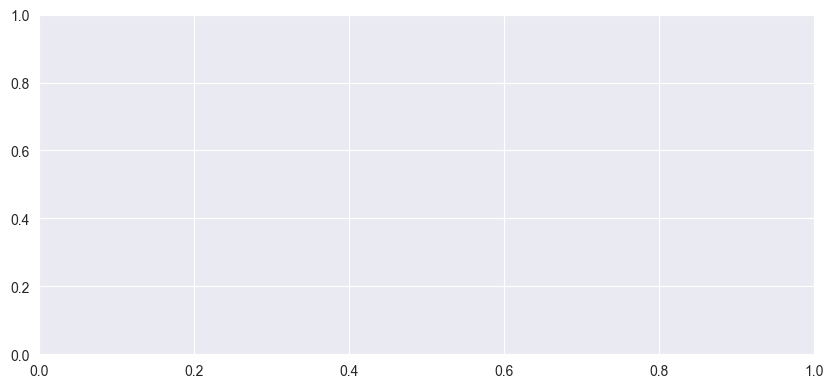

In [14]:
# unemployement rates across different categories
census_cols = ['at_or_above_pov_level_unemployment_r', 'pop_25_to_64_yrs_unemployment_r', 'bach_degree_unemployment_r']

plt.figure(figsize=(10,15))
# Loop through each column in census_cols
for i, col in enumerate(census_cols, 1):
    plt.subplot(3, 1, i)  # create a 3x1 grid of subplots
    plt.scatter(merged_df[col], merged_df['price'], s=25, alpha=0.35)
    plt.title(f'{col} vs Price', fontweight='bold')
    plt.xlabel(col, fontweight='bold')
    plt.ylabel('Price', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
census_cols.append('price')
plot_corr(data=merged_df[census_cols], annot=True)

Price appears to have a similar distribution across the three types of unemployment categories in our data frame. This is likely because the different unemployment categories are highly correlated with one another.

In [15]:
# count plot for property type
plt.figure(figsize=(10, 6))
sns.countplot(y='propertyType', data=merged_df, order=merged_df['propertyType'].value_counts().index)
plt.title('Distribution of Property Types', fontweight='bold')
plt.show()

NameError: name 'merged_df' is not defined

<Figure size 1000x600 with 0 Axes>

There are more observations with propertyType: 'Condo' than all other propertyTypes combined. This is likely because our data is from a densely populated urban area, that may lack adequate spaces for houses on individual plots.  

In [16]:
# box plot of price by property type
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', y='propertyType', data=merged_df)
plt.title('Price Distribution by Property Type', fontweight='bold')
plt.show()

NameError: name 'merged_df' is not defined

<Figure size 1000x600 with 0 Axes>

The Condo PropertyType appears to have the lowest median of all propertyTypes in the data. Interestingly, it has the second highest priced home in our dataset at around 37.5 million. The Multi-Family property Type contains the observation with the highest price at 40 Million. 

In [17]:
# calculate mean home price grouped by property type
price_by_propertyType = merged_df.groupby('propertyType')['price']
mean_price_propertyType = price_by_propertyType.mean()
mean_price_propertyType

NameError: name 'merged_df' is not defined

Townhouses appear to have the highest average housing price in the data. But it is important to note that there only appears to be a single observation for Townhouses in the data set. Of the three property types that have an adequate sample size (Condo, Multi-Family, and Single-Family). The Multi-Family observations unsurprisingly have the highest average housing price of 3.1 Million.

# Feature Engineering

## Initial Removal of Unwanted Features
We believe the features listed in the unwanted_features object will not provide predictive value to listing price. 
Notice that we will have to remove lot size because more than 50% of the data is missing.

In [18]:
unwanted_features = ['id', 'formattedAddress', 'addressLine1', 'addressLine2',
                     'state', 'county', 'geometry', 'index_right', 'statefp', 'countyfp',
                     'tractce', 'geoid', 'tract_name', 'namelsad', 'removedDate', 'lotSize', 'listingOffice',
                     'listedDate', 'createdDate', 'lastSeenDate', 'status'
                     ]
merged_df = merged_df.drop(columns=unwanted_features).copy()
merged_df.info()

NameError: name 'merged_df' is not defined

## Creation of Dummy Variables

After performing some initial feature filtration, we will convert our remaining categorical variables into a numerical format. This step will enable the machine learning algorithms we will use to interpret these features, while preserving the information present in these variables. 

In [19]:
# convert categoricals to dummy variables and replace categorical variables with dummies in the df 
categorical_features = ['propertyType', 'city', 'zipCode', 'listingType']
df_categorical = merged_df[categorical_features].copy()
df_categorical_dummies = pd.get_dummies(data=df_categorical, drop_first=True, dtype=int)
df_categorical_dummies.head()

NameError: name 'merged_df' is not defined

In [20]:
df_categorical_dummies.tail()

NameError: name 'df_categorical_dummies' is not defined

In [21]:
merged_df = merged_df.drop(columns=categorical_features).copy()
merged_df = pd.concat([merged_df, df_categorical_dummies], axis=1).copy()
merged_df.info()

NameError: name 'merged_df' is not defined

In [22]:
merged_df.info()

NameError: name 'merged_df' is not defined

## Feature Engineering - Creation of Density Feature

We will create a new feature 'density' to represent population density. To calculate the population density, we will take the area of each tract, and divide it by the total population of that tract. After calculating the population density of each feature, the 'area' and 'total_pop' features will be dropped.

In [23]:
merged_df[['total_pop', 'area']].describe()

NameError: name 'merged_df' is not defined

In [24]:
merged_df['density'] = merged_df['total_pop'] / merged_df['area']
print(merged_df[['density', 'total_pop', 'area']].describe())
merged_df = merged_df.drop(columns=['area', 'total_pop']).copy()

NameError: name 'merged_df' is not defined

In [25]:
merged_df[['density']].head()

NameError: name 'merged_df' is not defined

In [26]:
merged_df.info()

NameError: name 'merged_df' is not defined

## Normalization

Before we move onto correlation analysis and elminating features, we will normalize our numerical features. Normalizing our data can affect correlation values, so performing this step before correlation analysis is preferrable. We will determine whether our features are normally distributed by using Shapiro-Wilk test for normality. If they are not normally distributed, we will perform min-max scaling, otherwise we will use Z-score standardization.

In [27]:
# define the features and target 
features = merged_df.columns.tolist()
target = 'price'

# function to assess normality and decide appropriate normalization methods
def assess_normality(df, target):
    """
    Evaluates normality of features and suggests normalization methods.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the dataset features.
    - target (str): Name of the target variable to exclude from analysis.

    Returns:
    - DataFrame with results of normality test and suggested method of normalization
    """
    
    results = {}
    
    for feature in df.columns:
        # skip the target variable
        if feature == target:
            continue
        
        # perform Shapiro-Wilk test for normality
        stat, p_value = shapiro(df[feature].dropna())
        
        # save results
        results[feature] = {
            'shapiro_statistic': stat,
            'shapiro_p_value': p_value,
            'is_normal': p_value > 0.05  # true if feature appears normal
        }
    
    # suggest normalization technique based on normality results
    for feature, result in results.items():
        if result['is_normal']:
            results[feature]['suggested_normalization'] = 'Standardization (Z-score)'
        else:
            results[feature]['suggested_normalization'] = 'Min-Max Scaling'
    
    return pd.DataFrame(results).T

# display results for merged df
normality_results_df = assess_normality(merged_df, target)
normality_results_df[['shapiro_statistic', 'shapiro_p_value', 'is_normal', 'suggested_normalization']]

NameError: name 'merged_df' is not defined

In [28]:
# check if any features are normally distributed
normal_features_df = normality_results_df[normality_results_df['is_normal'] == True]
print(normal_features_df[['shapiro_statistic', 'shapiro_p_value', 'is_normal', 'suggested_normalization']])

NameError: name 'normality_results_df' is not defined

None of our features are normally distributed, so it is appropriate to use min-max scaling on these features. There are some features we should exclude from this however. We have created dummy variables which are already on a binary scale (0,1), we do not want to min-max scale them. We will also exclude the target variable 'price' from our normalization.

In [29]:
# features to normalize, exclude dummy variables and target 
features_to_scale = [
    'latitude', 'longitude', 'bedrooms', 'bathrooms', 
    'squareFootage', 'yearBuilt', 'daysOnMarket', 
    'occupied_housing_units', 'median_monthly_housing_cost',
    'median_household_income', 'median_housing_income_below_100k',
    'median_housing_income_100k_149k', 'median_housing_income_150k_above',
    'at_or_above_pov_level_unemployment_r', 
    'pop_25_to_64_yrs_unemployment_r', 'bach_degree_unemployment_r',
    'density'  
]

# initialize MinMaxScaler()
scaler = MinMaxScaler() 

# scale features and replace original features with scaled versions
merged_df_scaled = merged_df.copy()
merged_df_scaled[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale])

merged_df_scaled.info()

NameError: name 'merged_df' is not defined

In [30]:
merged_df_scaled

NameError: name 'merged_df_scaled' is not defined

## Correlation Analysis

In [31]:
corr_df = plot_corr(merged_df_scaled)

NameError: name 'plot_corr' is not defined

The below code sorts the absolute correlation values of all remaining features with price in descending order. These are the features that appear to have the highest impact on price. 

In [32]:
corr_price = pd.DataFrame(corr_df['price'])
corr_price['absolute_correlation'] = corr_price['price'].abs()
corr_price = corr_price.sort_values(by='absolute_correlation', ascending=False)
corr_price.head(10)

NameError: name 'corr_df' is not defined

In [33]:
corr_price.info()

NameError: name 'corr_price' is not defined

## Handling Multicollinearity

In this section we will attempt to reduce multicollinearity. Multicollinearity occurs when two or more independent variables are highly correlated, meaning that they provide redundant information about the variance of the target variable. This can make isolating the effects of the features on the target variable difficult, and result in worse model performance.

One of the goals of this project was to provide new insight into the effect of features on housing price that are not already well-known. The vast majority of home-buyers are aware that square footage, number of bathrooms, and number of bedrooms are positively correlated with housing price. These are variables that are also positively correlated with eachother; as the size of a house increases, the number of bathrooms and bedrooms generally increases as well. 

We will not be surprised to find that the feature with the largest impact on price is square footage, # of bathrooms, or # of bedrooms. With this in mind, we plan on only using one of these three variables to train our models. We are more interested in discovering the impact of certain features on price that are less obvious, even if the impact of these features is not as pronounced as the more well-known features above. We hope this will lead to more valuable insights that offer prospective homebuyers helpful information to support their path to homeownership.

In [34]:
def drop_multicollinearity_feats(corr_matrix: pd.DataFrame, target: str = 'price', threshold: float =.75) -> set:
    """
    This function takes a correlation matrix, a target variable, and a threshold as arguments,
    and returns a set of features that can be dropped from a DataFrame to reduce multicollinearity.
    
    Parameters:
    corr_matrix (pd.DataFrame): A DataFrame containing the correlation values between features.
    target (str): The target variable to consider when assessing correlations.
    threshold (float): The correlation threshold above which features are considered highly correlated.

    Returns:
    set: A set of feature names to drop due to high multicollinearity.
    """
    
    # convert correlation matrix to absolute values and create boolean mask for upper triangle
    corr_matrix = corr_matrix.abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    high_corr_pairs = np.where((corr_matrix > threshold) & mask)
    
    # identify features with correlation greater than threshold, add the pairs to a list
    high_corr_features = [(corr_matrix.columns[i], corr_matrix.columns[j]) for i, j in zip(*high_corr_pairs)]
    high_corr_features = [pair for pair in high_corr_features if target not in pair] # remove any pairs containing the target
    print(f"Highly correlated non-target feature pairs with absolute correlation > {threshold}:\n{high_corr_features}\n")
    multicol_features_to_drop = set() # create set to avoid adding duplicate features
    
    # add feature with lower correlation to target variable to the set of columns to drop
    for feat1, feat2 in high_corr_features:
        if corr_matrix.loc[feat1, target] > corr_matrix.loc[feat2, target]:
            multicol_features_to_drop.add(feat2)
        else:
            multicol_features_to_drop.add(feat1)

    return multicol_features_to_drop # return the set of features to drop


multicol_features = drop_multicollinearity_feats(corr_matrix=corr_df, target='price', threshold=.75)
print(f"Multicollinearity features to drop:\n{multicol_features}")

NameError: name 'corr_df' is not defined

Display correlation matrix of some high correlation feature pairs.

In [35]:
df_multicol = merged_df_scaled[['price','bedrooms', 'bathrooms','squareFootage', 'median_monthly_housing_cost', 'median_household_income']].copy()
corr_multicol = plot_corr(df_multicol, annot=True)

NameError: name 'merged_df_scaled' is not defined

In [36]:
corr_multicol

NameError: name 'corr_multicol' is not defined

In [37]:
# create a new df that drops the high multicollinearity features 
merged_df_reduced_multicol = merged_df_scaled.drop(columns=list(multicol_features)).copy()

# re-plot correlation matrix
corr_df = plot_corr(merged_df_reduced_multicol)

# display correlation matrix
corr_reduced = pd.DataFrame(corr_df)

NameError: name 'merged_df_scaled' is not defined

In [38]:
# repeat multicollinearity analysis with new reduced df
multicol_features = drop_multicollinearity_feats(corr_matrix=corr_reduced, target='price', threshold=.50)
multicol_features

NameError: name 'corr_reduced' is not defined

In [39]:
# drop the columns returned by the function 
# create a new df that drops the high multicollinearity features 
merged_df_reduced_multicol = merged_df_reduced_multicol.drop(columns=list(multicol_features)).copy()
merged_df_reduced_multicol.head()

NameError: name 'merged_df_reduced_multicol' is not defined

Now that we have addressed multicollinearity and removed non-target features with correlation values above .5, we will sort the absolute correlation values of each feature with price and see if any additional features should be removed before modeling.

In [40]:
# sort remaining features by absolute correlation with target-variable
corr_reduced_multicol = merged_df_reduced_multicol.corr()
corr_reduced_multicol_price = pd.DataFrame(corr_reduced_multicol['price'])
corr_reduced_multicol_price['absolute_correlation'] = corr_reduced_multicol_price['price'].abs()
corr_reduced_multicol_price = corr_reduced_multicol_price.sort_values(by='absolute_correlation', ascending=False)
corr_reduced_multicol_price

NameError: name 'merged_df_reduced_multicol' is not defined

Now we will remove all features with a correlation value with price less than .10. 

In [41]:
# get features with price-correlation < .10
low_price_corr_features = corr_reduced_multicol_price[corr_reduced_multicol_price['absolute_correlation'] < .10].index.tolist()
low_price_corr_features

NameError: name 'corr_reduced_multicol_price' is not defined

In [42]:
# final scaled dataframe with the relevant features and target
merged_df_final_scaled = merged_df_reduced_multicol.drop(columns=low_price_corr_features, axis=1).copy()

# get the list of features and target
final_features_and_target = merged_df_final_scaled.columns.tolist()

# make a datafraame with the original, raw data with only the relevant features and target. We will be standardizing inside the pipeline
ml_df = merged_df[final_features_and_target].copy()
ml_df.info()
ml_df.head()

NameError: name 'merged_df_reduced_multicol' is not defined

After removing features with low correlation values with price, we are left with 11 columns (10 remaining features). We will now begin building models that can best predict housing price based on the features of our data.

In [43]:
plot_corr(data=ml_df, annot=True)

NameError: name 'plot_corr' is not defined

## Modeling

### Splitting Data Into Train and Test

In [44]:
X = ml_df.drop(columns=['price']).copy()
y = ml_df['price'].copy()

# set seed for reproducibility
np.random.seed(42)
random.seed(42)

# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# dataset names
ds_names = ['X train', 'X test', 'y train', 'y test']

# dataset list
ds_list = [x_train, x_test, y_train, y_test]

# print the shape of each dataset
for i in range(len(ds_list)):
    print(ds_names[i],'shape: ',ds_list[i].shape)
    print()

NameError: name 'ml_df' is not defined

### Pipeline Setup

In [45]:
# create dictionary of different models to test
MODEL_DICT = {
    'ols': {'model': LinearRegression()},
    'tree': {'model': DecisionTreeRegressor(random_state=42)},
    'rfr': {'model': RandomForestRegressor(random_state=42)},
    'gbr': {'model': GradientBoostingRegressor(random_state=42)},
}
# get list of model names
models = list(MODEL_DICT.keys())

# for each model
for model_name in models:
    
    # initiate the model pipeline
    pipeline = Pipeline(
        [('scaler', StandardScaler()),
         ('knn_imputer', KNNImputer(n_neighbors=5)),
         ('model', MODEL_DICT[model_name]['model'])
         ],
    )
    
    print(f'Fitting {model_name} on Train Data')
    # fit on the train dataset
    pipeline.fit(X=x_train, y=y_train)
    
    # predict on the train dataset
    y_train_predictions = pipeline.predict(X=x_train)
    
    # predict on the test dataset
    y_test_predictions = pipeline.predict(X=x_test)
    
    # make dataframe to store train results
    train_results = pd.DataFrame(y_train.values, columns=['actual_price'])
    
    # add column to store predictions
    train_results['predicted_price'] = y_train_predictions
    
    # make dataset to store test results
    test_results = pd.DataFrame(y_test.values, columns=['actual_price'])
    
    # add column to store predictions
    test_results['predicted_price'] = y_test_predictions
    
    # make list of datasets
    dfs = [train_results, test_results]
    
    # make list of dataset names
    df_names = ['train_results', 'test_results']
    
    # make list of RMSE metric names
    rmse_names = ['rmse_train', 'rmse_test']
    
    # compute residuals, RMSE for each result
    for i in range(len(df_names)):
        df = dfs[i]
        df_name = df_names[i]
        df['residual'] = df['actual_price'] - df['predicted_price']
        
        MODEL_DICT[model_name][df_name] = df
        rmse = root_mean_squared_error(df['actual_price'], df['predicted_price'])
        MODEL_DICT[model_name][rmse_names[i]] = rmse
        

Fitting ols on Train Data


NameError: name 'x_train' is not defined

In [46]:
def plot_residuals(model_name: str):
    """
    Plot the distribution of residuals for a specified model.

    This function retrieves residuals from training and test data for a given model, then creates a two-panel plot
    to visualize the distribution of residuals for training and test sets.
    
    Params:
        model_name: str. The name of the model to plot the residuals for.
    """
    # get the train and test residuals in Pandas Series
    train_residuals = MODEL_DICT[model_name]['train_results']['residual']
    test_residuals = MODEL_DICT[model_name]['test_results']['residual']
    
    # get the standard deviation of the true price for train and test
    true_y_std_train = round(MODEL_DICT[model_name]['train_results']['actual_price'].std() / 1000000, 2)
    true_y_std_test = round(MODEL_DICT[model_name]['test_results']['actual_price'].std() / 1000000, 2)
    
    # initiate matplotlib figure
    fig, ax = plt.subplots(figsize=(17, 12), ncols=1, nrows=2)
    
    # compute histogram of residuals for train and test results
    sns.histplot(train_residuals, ax=ax[0])
    sns.histplot(test_residuals, ax=ax[1])
    
    # compute the RMSE for train and test
    rmse_train = round(MODEL_DICT[model_name]['rmse_train'] / 1000000, 2)
    rmse_test = round(MODEL_DICT[model_name]['rmse_test'] / 1000000, 2)
    
    # compute the mean residuals for train and test
    mean_residual_train = round(train_residuals.mean(), 3)
    mean_residual_test = round(test_residuals.mean(), 3)
    
    # set the titles for each figure
    ax[0].set_title(f'{model_name.upper()} | Residuals | RMSE Train: {rmse_train} million USD | True Price Std: {true_y_std_train} million USD | Mean Res.: {mean_residual_train}')
    ax[1].set_title(f'{model_name.upper()} | Residuals | RMSE Test: {rmse_test} million USD | True Price Std: {true_y_std_test} million USD | Mean Res.: {mean_residual_test}')
    
    plt.show()
    
    
plot_residuals(model_name='ols')

KeyError: 'train_results'

In [47]:
plot_residuals(model_name='tree')

KeyError: 'train_results'

In [48]:
plot_residuals(model_name='gbr')

KeyError: 'train_results'

In [49]:
plot_residuals(model_name='rfr')

KeyError: 'train_results'

In [50]:
def plot_feature_importances(model_name: str):
    '''
    Plots the feature importance of the selected model name.
    :param model_name: str. name of the model
    
    '''
    # if the model name is not tree, gbr, or rfr, then raise error
    if model_name not in ['tree', 'gbr', 'rfr']:
        raise ValueError(f"Cannot plot feature importance from this model: {model_name}")
    
    # get the feature importances
    feature_importances = MODEL_DICT[model_name]['model'].feature_importances_
    
    # get the feature names
    feature_names = ml_df.drop(columns=['price']).columns.tolist()
    
    # initiate the figure
    fig, ax = plt.subplots(figsize=(17, 5), ncols=1, nrows=1)
    
    # make dataframe of feature importances
    data = pd.DataFrame({'importance': feature_importances, 'feature': feature_names})
    
    # sort features by importance
    data = data.sort_values(by='importance', ascending=False)
    
    # build barplot
    sns.barplot(data=data, x='feature', y='importance', ax=ax)
    
    # set ticks for x axis
    plt.xticks(rotation=45)
    
    # set title
    plt.title(f'Feature Importances for {model_name.upper()} Model')
   
plot_feature_importances(model_name='tree') 


NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
plot_feature_importances(model_name='rfr')

In [ ]:
plot_feature_importances(model_name='gbr')

In [51]:
def plot_actual_vs_predicted(model_name: str, model_dict: dict):
    """
    Plots Actual vs Predicted prices for the given model on the test data

    Parameters:
    - model_name: str, name of model to plot
    - model_dict: dictionary containing model results including predictions

    Returns:
    - scatter plot of Actual vs Predicted values for model
    """
    
    # extract test data actuals vs preds from model_dict
    test_results = model_dict[model_name]['test_results']
    test_actual = test_results['actual_price']
    test_predicted = test_results['predicted_price']
    
    # scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(test_actual, test_predicted, color='green', alpha=0.6, label='Test Data')
    plt.plot([min(test_actual), max(test_actual)], [min(test_actual), max(test_actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'{model_name.upper()} - Actual vs Predicted (Test)')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.legend()
    plt.grid(True)
    plt.show()


In [52]:
plot_actual_vs_predicted('ols', MODEL_DICT)

KeyError: 'test_results'

In [53]:
plot_actual_vs_predicted('tree', MODEL_DICT)

KeyError: 'test_results'

In [54]:
plot_actual_vs_predicted('rfr', MODEL_DICT)

KeyError: 'test_results'

In [55]:
plot_actual_vs_predicted('gbr', MODEL_DICT)

KeyError: 'test_results'

## Initial Modeling Results

When taking it to account the mean residuals and RMSE, it appears the best performing models were the the Random Forest Regressor (RFR) and the Gradient Boost Regressor (GBR).

Random Forest Regressor  
Test RMSE: 1.7 million USD  
Test Mean Residuals: 137,529.98 USD  

Gradient Boost Regressor  
RMSE: 1.68 million USD  
Mean Residuals: 177,456.42 USD  

The Random Forest Regressor achieves the lowest mean residuals and the second lowest RMSE. The Gradient Boost Regressor achieved the lowest RMSE and the second lowest mean residuals. The RMSE of the RFR model was 20,000 more than the GBR model, but the mean residuals was 40,000 less than the GBR model. Taking both of these into account, the RFR performed the best overall. 

The RMSE metric indicates that, on average, the model deviates from the true values by 1.7 million USD. RMSE can be interpreted as the standard deviation of the prediction errors. The RFR's RMSE is significantly lower than 1 standard deviation of the true house prices, suggesting that the model’s errors are less variable than the actual prices. This implies that the model performs much better than random selection. However, despite this, there is still considerable error in the predictions, with deviations in the magnitude of millions of USD. This could be attributed to the fact that housing prices can be very large, which can amplify the error.

We also plotted the feature importances for the ensemble and tree models. The feature importances help us understand which features provided the most information about the variance of housing price. We can see that there is a general consensus of the following 3 most important features: square footage, latitude, and median monthly housing cost. 

Square Footage: High positive correlation to price.

Latitude: Information on location tells us that it has predictive value.

Median Monthly Housing Cost: Provides information the median monthly housing cost by Tract according to the US Census - providing useful information about housing prices in the area.

Actuals vs Predicted plots:
The actuals vs predicted plots for RFR and GBR are very similar, there are some significant outliers at the higher range of housing prices, which may need to be dealt with in order to minimize the RMSE and mean residuals of our models.

## Outlier Removal

In an attempt to improve model performance, we will use the Interquartile range method to remove extreme values of price. Observations of price that are greater than Q3 + 4*(Q3 - Q1) or less than Q1 - 4*(Q3 - Q1) will be removed. This may improve our models' ability to predict price. Initially an upper threshold of Q3 + 1.5*(Q3 - Q1) and a lower threshold of Q1 - 1.5*(Q3 - Q1) was tested, but these thresholds removed 160 observations (>10% of the data). The thresholds were modified to a wider range in order to maintain some of the real world variability of housing price.

In [56]:
# copy df
df_no_outliers = ml_df.copy()

# calculate IQR for 'price' 
Q1 = df_no_outliers['price'].quantile(0.25)  # 25th percentile
Q3 = df_no_outliers['price'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1

# define threshold for outliers
lower_bound = Q1 - 4 * IQR
upper_bound = Q3 + 4 * IQR

# filter out the outlier observations
df_no_outliers = df_no_outliers[(df_no_outliers['price'] >= lower_bound) & (df_no_outliers['price'] <= upper_bound)]

# see how many observations were removed
print("Original shape:", merged_df_final_scaled.shape)
print("New shape after removing outliers:", df_no_outliers.shape)


NameError: name 'ml_df' is not defined

In [57]:
plot_corr(data=df_no_outliers, annot=True)

NameError: name 'plot_corr' is not defined

80 outliers were removed from the data frame. Now we will re-split our data in to train and test sets.

In [58]:
# re-assign features and target after removing outliers
X_no_outliers = df_no_outliers.drop(columns='price') 
y_no_outliers = df_no_outliers['price'] 

# split data after outlier removal
x_train_no_outliers, x_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

NameError: name 'df_no_outliers' is not defined

## Hyperparameter Tuning

GridSearchCV will be used to test multiple sets of hyperparameters and return the best performing set. It performs cross-validation to evaluate model performance, meaning the model is evaluated several times on different splits of the data. This can reduce the risk of over/under-fitting and increases our chances of reducing RMSE for each model.

In [59]:
# define parameter grids 
param_grids = {
    'ols': {},  # no hyperparameters for LinearRegression
    'tree': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],  
        'model__min_samples_leaf': [1, 2], 
        'model__max_features': ['sqrt', 'log2', None], 
    },
    'rfr': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],  
        'model__min_samples_leaf': [1, 2], 
    },
    'gbr': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 10]
    }
}

In [60]:
# use GridSearchCV as search method
search_method = GridSearchCV 

for model_name in MODEL_DICT.keys():
    print(f"Tuning hyperparameters for {model_name.upper()}")
    
    # define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn_imputer', KNNImputer(n_neighbors=5)),
        ('model', MODEL_DICT[model_name]['model'])
    ])
    
    param_grid = param_grids.get(model_name, {})
    
    search = search_method(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error', 
        cv=5,
        n_jobs=-1
    )
    
    # fit to training data
    search.fit(x_train_no_outliers, y_train_no_outliers)
    
    # store the best estimator/results
    best_pipeline = search.best_estimator_
    MODEL_DICT[model_name]['best_params'] = search.best_params_
    MODEL_DICT[model_name]['best_score'] = -search.best_score_  

    # predict
    y_train_predictions = best_pipeline.predict(x_train_no_outliers)
    y_test_predictions = best_pipeline.predict(x_test_no_outliers)
    
    # stores preds and residuals
    train_results = pd.DataFrame({
        'actual_price': y_train_no_outliers,
        'predicted_price': y_train_predictions
    })
    test_results = pd.DataFrame({
        'actual_price': y_test_no_outliers,
        'predicted_price': y_test_predictions
    })
    train_results['residual'] = train_results['actual_price'] - train_results['predicted_price']
    test_results['residual'] = test_results['actual_price'] - test_results['predicted_price']
    
    # RMSE calc
    def root_mean_squared_error(actual, predicted):
        return np.sqrt(((actual - predicted) ** 2).mean())

    MODEL_DICT[model_name]['train_results'] = train_results
    MODEL_DICT[model_name]['test_results'] = test_results
    MODEL_DICT[model_name]['rmse_train'] = root_mean_squared_error(train_results['actual_price'], train_results['predicted_price'])
    MODEL_DICT[model_name]['rmse_test'] = root_mean_squared_error(test_results['actual_price'], test_results['predicted_price'])
    
    print(f"Best parameters for {model_name.upper()}: {MODEL_DICT[model_name]['best_params']}")
    print(f"Train RMSE: {MODEL_DICT[model_name]['rmse_train']}, Test RMSE: {MODEL_DICT[model_name]['rmse_test']}\n")

Tuning hyperparameters for OLS


NameError: name 'x_train_no_outliers' is not defined

In [61]:
plot_residuals(model_name='ols')

KeyError: 'train_results'

In [62]:
plot_residuals(model_name='tree')

KeyError: 'train_results'

In [63]:
plot_residuals(model_name='rfr')

KeyError: 'train_results'

In [64]:
plot_residuals(model_name='gbr')

KeyError: 'train_results'

In [65]:
plot_feature_importances(model_name='tree') 

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [66]:
plot_feature_importances(model_name='gbr') 

NotFittedError: This GradientBoostingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [67]:
plot_feature_importances(model_name='rfr') 

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Although the top 3 features for each model are all the same, the rankings of median_monthly_housing_cost and latitude are swapped in the RFR model which has latitude as the second most important feature, and median monthly housing cost as the third. The feature importance rankings after the top 3 features were more mixed among the different models. Days on Market, Density, and zip code 02115 appeared to have some effect on price but were not as significant as square footage, median monthly housing cost, and latitude.

In [ ]:
plot_actual_vs_predicted('ols', MODEL_DICT)

In [ ]:
plot_actual_vs_predicted('tree', MODEL_DICT)

In [ ]:
plot_actual_vs_predicted('rfr', MODEL_DICT)

In [68]:
plot_actual_vs_predicted('gbr', MODEL_DICT)

KeyError: 'test_results'

## Model Results after Outlier Removal / Hyperparameter Tuning

Test RMSE  
OLS: 868,696.38 USD  
Tree: 733,867.41 USD  
Random Forest: 641,707.12 USD  
Gradient Boosting: 616,504.17 USD  

Test Mean Residuals  
OLS: -4,852.56 USD  
Tree: -6,424.10 USD  
Random Forest: 564.67 USD  
Gradient Boosting: -9,522.15 USD  

When taking it to account the mean resdiuals and RMSE, it appears the best performing models were once again the Random Forest Regressor (RFR) and the Gradient Boost Regressor (GBR). The Random Forest Regressor once again achieved the lowest mean residuals and the second lowest RMSE. The Gradient Boost Regressor achieved the lowest RMSE and the second lowest mean residuals. The RMSE of the RFR model was 25,000 more than the GBR model, but the mean residuals was much closer to 0 at 564.67 USD, while the GBR model had the highest absolute mean residuals at -9,522.15 USD. 

If we were primarily concerned with model bias, we would select the Random Forest Regressor once again. A model with mean residuals close to zero indicates that the model is not consistently overestimating or underestimating the target value, making it more reliable in terms of bias. However, when compared to the mean housing price of the data used to train the model of 1,477,669 USD - a mean residuals of -9,522 USD is not very significant. Therefore, for our final model we will choose the Gradient Boosting Regressor with the lowest test RMSE of 616,504.17 USD as our final model.

Gradient Boost Regressor  
Test RMSE: 616,504.17 USD  
Test Mean Residuals: -9,522.15 USD  

Tuning hyperparameters for GBR
Best parameters for GBR: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Train RMSE: 112593.2674, Test RMSE: 616504.1662

In [69]:
# median price of df with removed outliers
df_no_outliers['price'].median()

NameError: name 'df_no_outliers' is not defined

In [70]:
# mean price of df with removed outliers
df_no_outliers['price'].mean()

NameError: name 'df_no_outliers' is not defined

Test RMSE and Test Mean Residuals comparison plot.

/var/folders/0p/2j4j5g2150b9zthf4j3gkgkr0000gn/T/ipykernel_17748/2319287407.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Model'], y=df['Test RMSE'], ax=ax1, palette='Blues_d', edgecolor='black')
/var/folders/0p/2j4j5g2150b9zthf4j3gkgkr0000gn/T/ipykernel_17748/2319287407.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['Model'], y=df['Test Mean Residuals'], ax=ax2, palette='Reds_d', edgecolor='black')


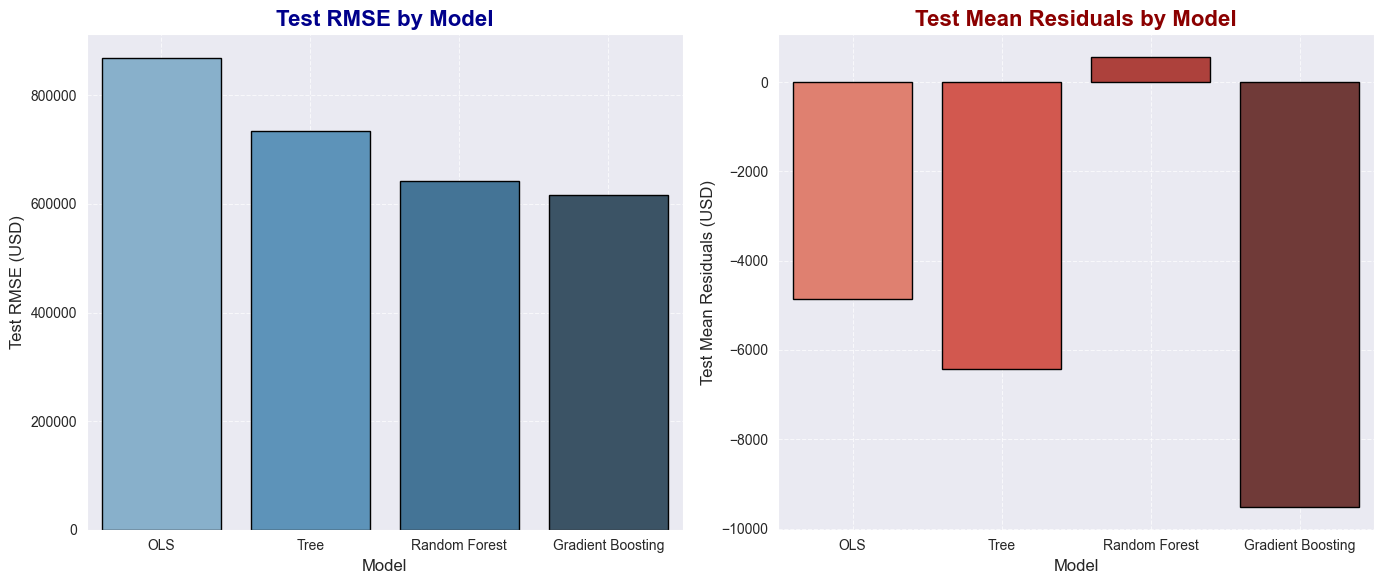

In [71]:
data = {
    'Model': ['OLS', 'Tree', 'Random Forest', 'Gradient Boosting'],
    'Test RMSE': [868696.38, 733867.41, 641707.12, 616504.17],
    'Test Mean Residuals': [-4852.56, -6424.10, 564.67, -9522.15]
}

df = pd.DataFrame(data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.set(style="whitegrid")

# plot bars for Test RMSE on ax1
sns.barplot(x=df['Model'], y=df['Test RMSE'], ax=ax1, palette='Blues_d', edgecolor='black')
ax1.set_title('Test RMSE by Model', fontsize=16, fontweight='bold', color='darkblue')
ax1.set_ylabel('Test RMSE (USD)', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)

# plot bars for Test Mean Residuals on ax2
sns.barplot(x=df['Model'], y=df['Test Mean Residuals'], ax=ax2, palette='Reds_d', edgecolor='black')
ax2.set_title('Test Mean Residuals by Model', fontsize=16, fontweight='bold', color='darkred')
ax2.set_ylabel('Test Mean Residuals (USD)', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=10)

# add gridlines
ax1.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Reflection on Effect of Outlier Removal

After removing outliers and tuning our hyperparameters, there is a significant improvement in the test RMSE and mean residuals of our models. However, it is important to note that after removing the 80 most extreme outliers that fell outside of our defined threshold, the variance of the target-variable was drastically reduced. In the original DF, the true price std dev was 3.52 Million. In the modified DF, true price std dev was 1.27 million. This reduction in price variance likely played a large role in the reduction of the RMSE of our tuned models.

Ratio of previous vs. new true price std. dev = 3.52 Million/1.27 Million = 2.77

The RMSE metric indicates that, on average, the GBR model deviates from the true values by 616,504.17 USD. RMSE can be interpreted as the standard deviation of the prediction errors. The GBR's RMSE is significantly lower than 1 standard deviation of the true house prices, which was 1.27 Million in our data. This suggests that the model’s errors are less variable than the actual prices.

The feature importances for the second round of trained models were approximate to the original models. When comparing the original GBR features importance, there are no standout differences from the second GBR model that was trained. The Top 3 important features in order are still as follows: square footage, latitude, and median monthly housing cost.

Square Footage: High positive correlation to price.

Latitude: Information on location tells us that it has predictive value.

Median Monthly Housing Cost: Provides information the median monthly housing cost by Tract according to the US Census - providing useful information about housing prices in the area.

Actuals vs Predicted plots: 
The actuals vs predicted plots are on a different scale now that the extreme outliers have been removed. It may appear there are less outliers in the original actual vs predicted plots, but the range in the original plots is from 0 to 40 million, while the range on the second round of plots are from 0 to 7 Million. This means the second round of plots are zoomed in significantly when compared to the first, and the predicted prices are actually far closer to the actuals housing prices than when compared to the original. 

# Conclusion
Large Variations in housing price, even among homes located in the same county, present unique challenges when attempting to predict housing prices. 

## Impact and Initial Goal
Our planned goal was to analyze and understand the key factors that influence the home prices in Suffolk County, MA (Boston, MA). Additionally, we wanted to see if we could find insights that could help homebuyers to improve their chances of achieving homeownership in the future. 

### Goal #1 - Analysis and Understanding of Key Driving Factors of Price
The key features that were identified from the models that were exposed to the complete data, as well as the tuned models that were exposed to data without the outliers, were the following: 
- square footage: higher squared footage leads to higher prices.
- latitude: higher latitude in Suffolk County somewhat leads to higher prices.
- median housing price: US Census data on median housing price is a quick predictor of expected housing prices today.
- days on market: slight positive correlation with housing price. This is intuitive, as higher prices homes may take longer to sell. If a house is priced competitively (lower), it will likely not be on the market as long.
- density: positive correlation with price. The more amount of residents per area, the higher the housing prices in a particular tract. This is intuitive as it likely indicates a higher amount of housing demand for a given supply - a phenomenon which generally increases prices.
- zip codes: some zip codes have a slight positive correlation with price, and others have a are slightly negatively correlated with price. This is likely due to characteristics of the area that are not necessarily captures in our models, like proximity to businesses, quality of public schools, and crime rates.

### Goal #2 - Provide Homebuyers with Insights to Achieve Homeownership
Homeowners that want to minimize their cost of buying a house should look at houses with small square footage, located in the southern part of Suffolk County, and find tracts where median monthly housing cost are lower per the US Census. They can also look for housing in areas that are less densely populated and seek out houses that have been on the market for a while. Zip Code 02128 was the only zip code in our final model that was negatively associated with price, homebuyers in Suffolk County can search for listings in this Zip Code and avoid looking for houses in Zip Codes 02115 and 02116, both of which were positively correlated with price. 

## Initial Project Hypothesis
At the beginning of the poject we expected that the factors "income", "average levels of education", and "population density" were positively correlated with price. The most important US Census feature used by our models is "median housing price". Density had a weak correlation with price, but not as strong as we intitially hypothesized. This is likely because population density, does not directly correspond to the ratio of houses on the market and people looking to buy a house in the area. We looked at unemployment rates of those with bachelor's degrees, but did not find a strong correlation with housing price. This is likely because those that are unemployed are unable to afford a home to begin with, and therefore do not have a large impact on the cost of housing in the area.

## Will this Information Benefit Prospective Home-Buyers? 
We believe that some of this information will be useful to prospective home-buyers, however, much of the results revealed by our models revealed commonly known information. It is self-evident that larger houses with more square footage are more expensive, and that areas with higher median monthly housing cost, have more expensive housing. Some of the more interesting results were based on location, days on market, and particular zip codes. These are characteristics that are may be less known to the public, and could actually provide some valuable information, although these features do not have as strong an impact on price as square footage.

Nevertheless, there are important factors that we did not consider in the scope of our project. These factors include: images of house interiors and backyard/frontyard, the size of housing plots, proximity to businesses and quality schools, crime rate, etc. In this project we focused on data that could be quickly quantified, such as bedroom count, bathroom count, year of construction, median housing price, education level, unemployment rate etc. The features that were analyzed should not be considered as the only factors that impact housing price.

## Final Thoughts / Reflection on Project Success
Although our results were not as transformative as we had hoped, any insights that give homebuyers a slight advantage in the market are valuable. To truly understand the nuances of housing prices and find more affordable options, homebuyers should take a holistic view of the housing market. Prospective buyers should create a thorough list of the housing characteristics that are less important to them. By identifying these areas where they are willing to compromise, they can make smaller sacrifices that collectively lead to substantial cost savings, potentially making their first home purchase possible.